## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Import packages and define useful functions

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
from IPython.display import HTML
%matplotlib inline

In [2]:
import math, sys


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
#     return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size=3):
    """Applies median blurring"""
    return cv2.medianBlur(img, kernel_size)

def bilateral_blur(img, d, sigmaColor, sigmaSpace ):
    """Applies bilateral filter for image smoothing"""
    return cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# ancillary functions for draw_lines
def initialize_buffers():
    """ Initialize the buffers which are global variables as empty arrays"""
    global x_rightLane, x_leftLane, y_rightLane, y_leftLane
    
    x_rightLane = []  # collection of x values for the right lane
    x_leftLane = []  # collection of x values for the left lane
    y_rightLane = []  # collection of y values for the right lane
    y_leftLane = []  # collection of y values for the left lane
    return


def update_buffers(x_buffer, y_buffer, x1, x2, y1, y2):
    """ Save new values of X's and Y's in the buffer arrays"""
    if len(x_buffer) <= 100:
        x_buffer.append(x1)
        x_buffer.append(x2)
        y_buffer.append(y1)
        y_buffer.append(y2)
    else:
        # replace the oldest values
        x_buffer[0] = x1
        x_buffer[1] = x2
        y_buffer[0] = y1
        y_buffer[1] = y2
        # rotate the data location so that the latest will be at the last index
        x_buffer = np.roll(x_buffer, -2)
        y_buffer = np.roll(y_buffer, -2)
    
    return x_buffer, y_buffer


def extrapolate_line(x_buffer, y_buffer, img, color, thickness):
    """ Extrapolate and draw a line that fits the coordinates defined by X's and Y's in the buffers"""
    imshape = img.shape  
    w1 = np.polyfit((y_buffer), (x_buffer), 1)
    y_series = np.linspace(imshape[0]*0.63, imshape[0], imshape[0]*0.4)
    fcn = np.poly1d(w1)
    x_series = fcn(y_series)
    for i in range(1,len(y_series)):
        cv2.line(img,(int(x_series[i-1]),int(y_series[i-1])), (int(x_series[i]),int(y_series[i])), color, thickness)
    return


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    imshape = img.shape  
    global x_rightLane, x_leftLane, y_rightLane, y_leftLane
    
    # save X's and Y's into the buffers
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = round((y2-y1)/((x2-x1)+1e-100), 3) * 180/ math.pi  # slope in degree units
                
                if -30 < slope < 30: # filter out lines with slope that are close to horizontal
                    pass
                else:
#                     cv2.line(img,(x1,y1), (x2,y2), color, thickness)  # to display original detected lines
                    # segregate points belonging to the left lane and right lane based on x values
                    if (imshape[1]*0.1 < x1 < imshape[1]*0.5) or (imshape[1]*0.1 < x2 < imshape[1]*0.5): 
                        x_leftLane, y_leftLane = update_buffers(x_leftLane, y_leftLane, x1,x2,y1,y2)    
                        
                    elif (imshape[1]*0.5 < x1 <imshape[1]*0.9) or (imshape[1]*0.5 < x2 <imshape[1]*0.9):
                        x_rightLane, y_rightLane = update_buffers(x_rightLane, y_rightLane, x1,x2,y1,y2)
                    else:
                        pass
    except NameError:
        # first frame is empty
        initialize_buffers()     
    except:
        print('Error: ', sys.exc_info()[1])
    
    # extrapolate  and draw lane lines
    try:
        extrapolate_line(x_leftLane, y_leftLane, img, color, thickness)  # fit line for the left lane
        extrapolate_line(x_rightLane, y_rightLane, img, color, thickness)  # fit a line for the right lane
        
#           print(len(x_leftLane), len(x_rightLane))  # to check how many points approximately are detected in each video frame 
    except NameError:
        # first frame is empty
        initialize_buffers()        
    except TypeError:
        pass
    except:
        print('Error: ', sys.exc_info()[1])
        
    return
        
 
              
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    

In [3]:
def get_calibrationPoints(display=True):
    """
    Derive the calibration points based on chessboard images
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    o_points = [] # points from original image
    c_points = [] # corner points in image plane.

    images = glob.glob('camera_cal/*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            o_points.append(objp)
            c_points.append(corners)

            # Draw and display the corners
            if display==True:
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
                ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image', fontsize=18)
                ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax2.set_title('With Corners', fontsize=18)
    
    return o_points, c_points



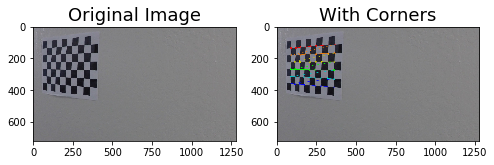

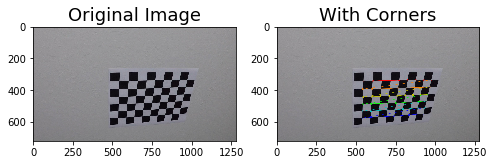

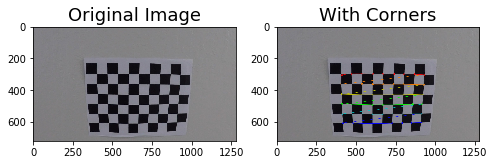

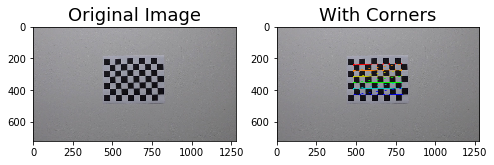

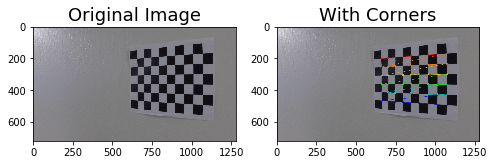

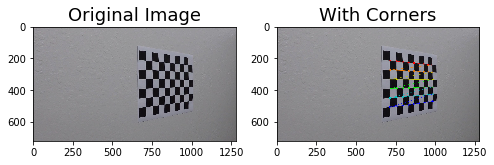

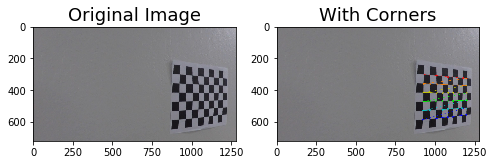

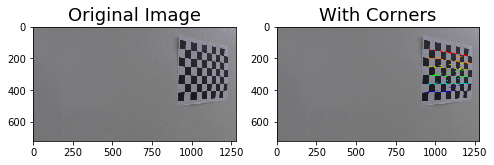

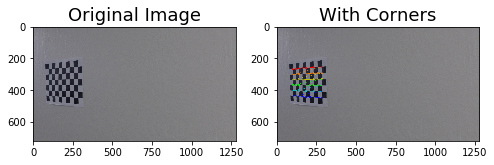

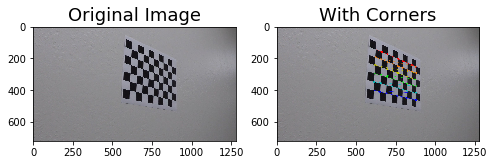

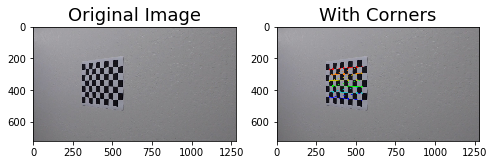

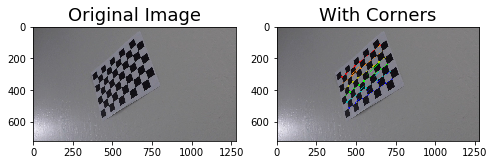

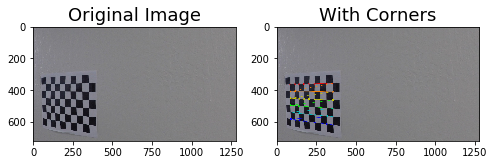

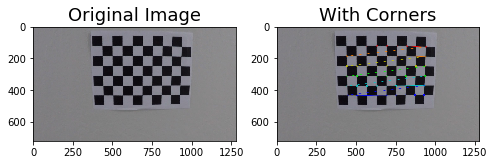

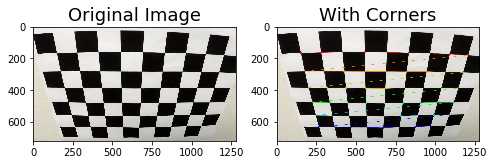

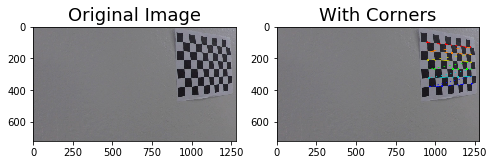

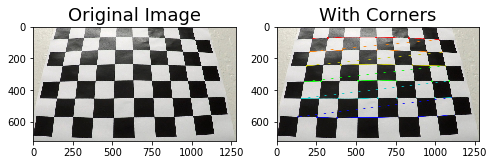

In [4]:
global o_points, c_points
o_points, c_points = get_calibrationPoints(display=True)

### Apply a distortion correction to raw images.
    

In [5]:
def calibrate_cam(image, obj_points, corner_points):
    """ Calibrate the camera taking the image using the points from the chessboard corners"""
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, corner_points, img_size, None, None)
    
    return ret, mtx, dist, rvecs, tvecs


    
def correct_distortion(image, display=False):
    """
    Correct the distortion in raw images
        image = input image
        read = True if img is a filename
        display = True if user intends to show the output image
    """
    global o_points, c_points
    
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    ret, mtx, dist, rvecs, tvecs = calibrate_cam(img, o_points, c_points)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    if display==True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=20)
        ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted', fontsize=20)
    
    return undistorted
    

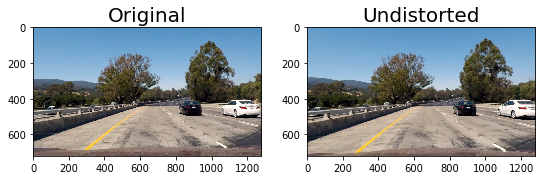

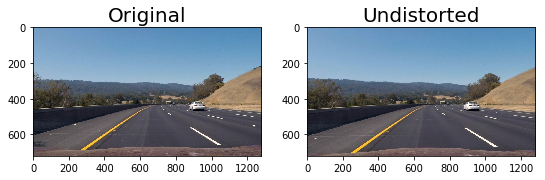

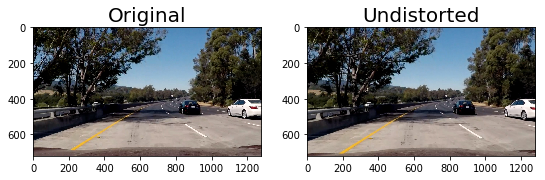

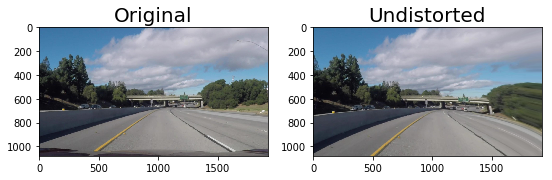

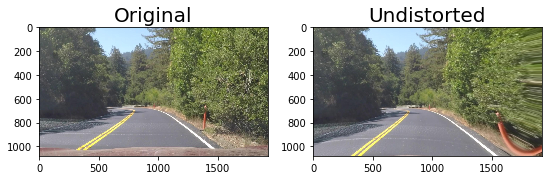

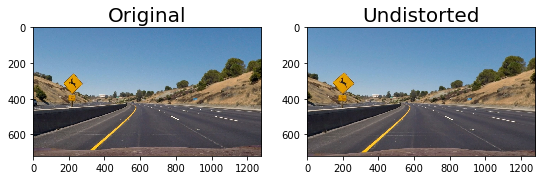

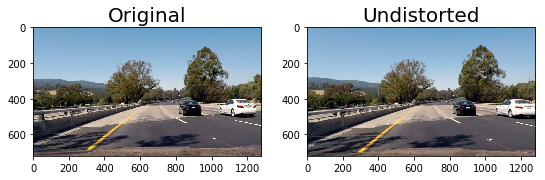

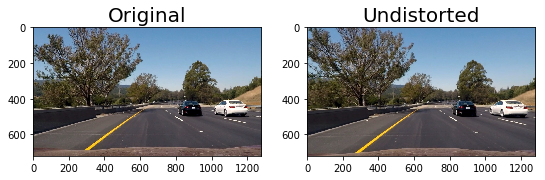

In [6]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    correct_distortion(image, display=True)

### Apply a perspective transform to rectify binary image ("birds-eye view").
    

In [7]:
# Perform perspective transform

def CLAHE(img, clipLimit=20.0, tileGridSize=(8,8)):
    """Applies Contrast Limiting Adaptive Histogram Equalization"""
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    img2=img.copy() 
    try:
        for i in range(img.shape[2]):
            img2[:, :, i] = clahe.apply(img[:, :, i])
    except:
        img2 = clahe.apply(img)
    return img2

def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size=3):
    """Applies median blurring"""
    return cv2.medianBlur(img, kernel_size)

def bilateral_blur(img, d=7, sigmaColor=50, sigmaSpace=50 ):
    """Applies bilateral filter for image smoothing"""
    img2=img.copy() 
    try:
        for i in range(img.shape[2]):
            img2[:, :, i] = cv2.bilateralFilter(img[:, :, i],d,sigmaColor,sigmaSpace) 
    except:
        img2 = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
    return img2

def normalize(img):
    """ Normalize the image"""
    return cv2.normalize(img,img,0,255,cv2.NORM_MINMAX)
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

    
def top_view(image, display=False):
    """
    Change perspective of the image to top view of the road
        img = the input image
        display = True if displaying the output images is desired
        read = True if img is a filename
    """
    try:
        img = cv2.imread(image)
    except:
        img = image
    
    imshape = img.shape
    vertices = np.array([[(imshape[1]*0.1,imshape[0]*0.95), (imshape[1]*0.1, imshape[0]*0.0),\
                          (imshape[1]*0.9, imshape[0]*0.0), (imshape[1]*0.9,imshape[0]*0.95)\
#                           (imshape[1]*0.65,imshape[0]*0.95), (imshape[1]*0.55, imshape[0]*0.30),\
#                           (imshape[1]*0.45,imshape[0]*0.30), (imshape[1]*0.35, imshape[0]*0.95)\
                         ]], dtype=np.int32)
    
    
    undistorted = img #correct_distortion(img, display = False) 
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    
    src_x1 = int(0.400*img_size[0])
    src_x2 = int(0.600*img_size[0])
    src_x3 = int(1.000*img_size[0])
    src_x4 = int(0.000*img_size[0])
    src_y1 = int(0.655*img_size[1])
    src_y2 = int(0.655*img_size[1])
    src_y3 = int(1.000*img_size[1])
    src_y4 = int(1.000*img_size[1])
    
    dst_x1 = int(0.00*img_size[0])
    dst_x2 = int(1.00*img_size[0])
    dst_x3 = int(0.85*img_size[0])
    dst_x4 = int(0.10*img_size[0])
    dst_y1 = int(0.00*img_size[1])
    dst_y2 = int(0.00*img_size[1])
    dst_y3 = int(1.00*img_size[1])
    dst_y4 = int(1.00*img_size[1])
    
    offset = 0
    src = np.float32([[src_x1,src_y1],[src_x2,src_y2],
                      [src_x3,src_y3],[src_x4,src_y4]])
    dst = np.float32([[dst_x1,dst_y1],[dst_x2,dst_y2], 
                     [dst_x3,dst_y3],[dst_x4,dst_y4]])
    
    M_warp = cv2.getPerspectiveTransform(src, dst)
    M_unwarp = cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(undistorted, M_warp, img_size)
    # improve image
    warped = normalize(warped)
#     warped = CLAHE(warped)
#     warped = bilateral_blur(warped)
    
#     warped = region_of_interest(warped, vertices)
    
    
    if display==True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped, M_unwarp

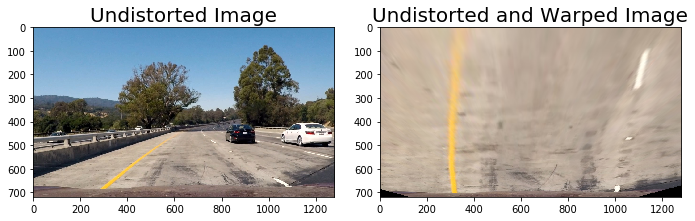

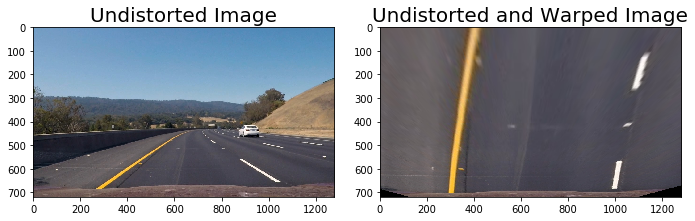

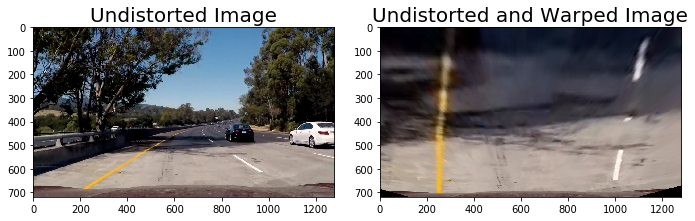

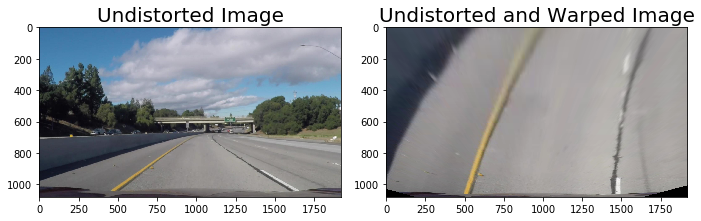

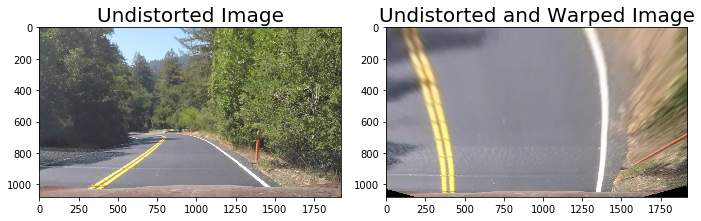

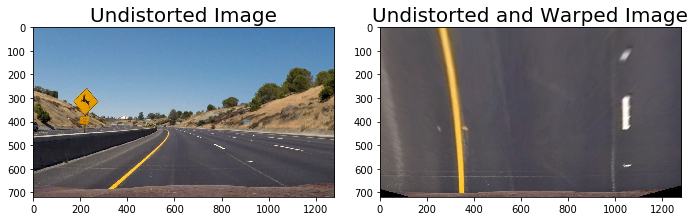

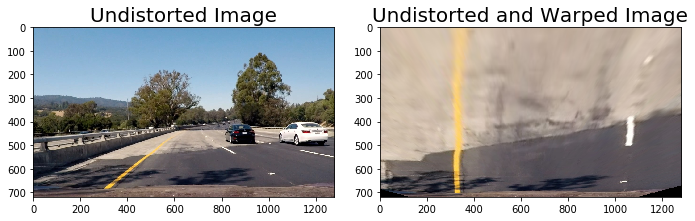

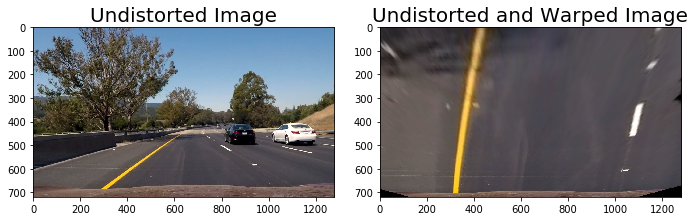

In [8]:
for image in glob.glob('test_images/test*.jpg'):
    top_view(image,display=True)

### Use color transforms, gradients, etc., to create a thresholded binary image.
    

In [34]:

def create_binary(image, display=False):
    """
    Create a binary thresholded images to emphasize the lane lines
        image = the input image
        display = True if displaying the output is desired
    """
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    
    img, M_unwarp = top_view(img, display = False)
    

    # use certain channel from different image encoding
#     l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]  # detects dark to white
    l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB)) # detects blue to yellow
    
    b_channel = CLAHE(b_channel, clipLimit=30.0, tileGridSize=(30,30))
    b_channel = bilateral_blur(b_channel, d=7, sigmaColor=100, sigmaSpace=100)
    
    l_channel = CLAHE(l_channel, clipLimit=3.0, tileGridSize=(30,30))
    l_channel = bilateral_blur(l_channel, d=7, sigmaColor=100, sigmaSpace=100)
    
    # Threshold color channel
    b_thresh_min = 225
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    
    if display == True:
        # Plotting thresholded images
        f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
                
        ax1.set_title('Top view', fontsize=16)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        ax2.set_title('b channel', fontsize=16)
        ax2.imshow(b_binary)
        
        ax3.set_title('l channel', fontsize=16)
        ax3.imshow(l_binary)

        ax4.set_title('Combined color thresholds', fontsize=16)
        ax4.imshow(combined_binary, cmap='gray')
            
    return combined_binary, M_unwarp

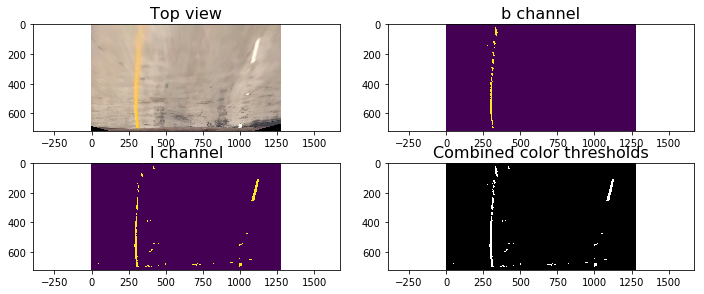

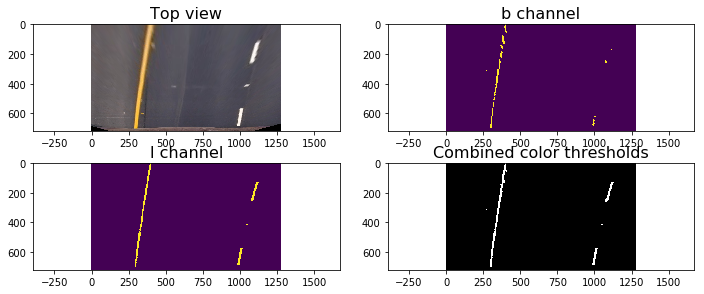

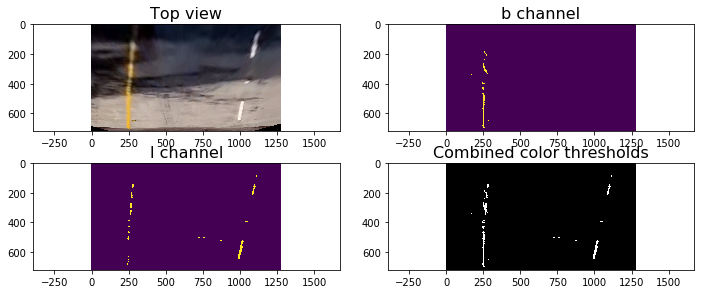

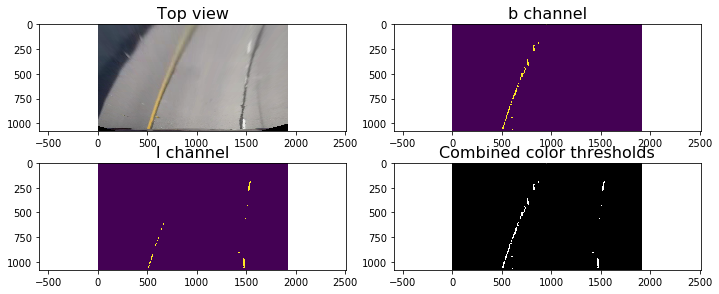

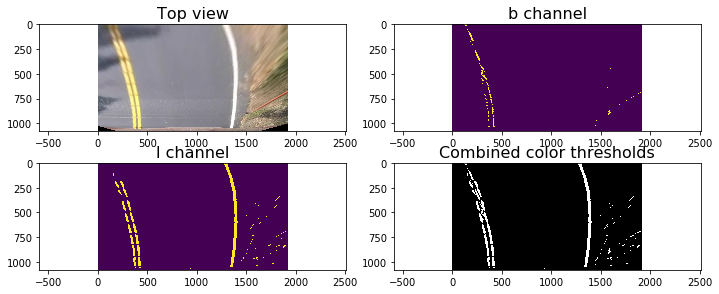

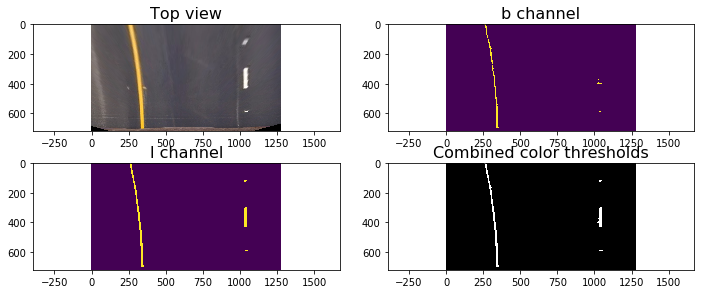

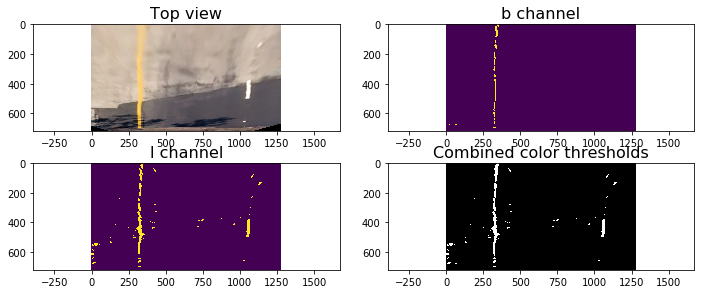

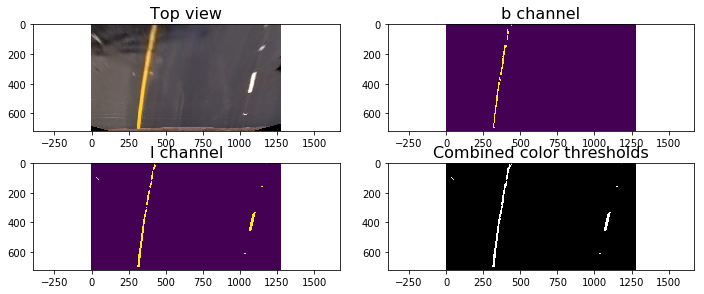

In [35]:
for image in glob.glob('test_images/test*.jpg'):
    create_binary(image, display=True)

### Detect lane pixels and fit to find the lane boundary.    

In [39]:


def pipeline(image, display=False):
    """
    Annotate the image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    
    try:
        img = cv2.imread(image)
    except:
        img = image
        
        
    binary_img, M_unwarp = create_binary(img, display=False)
    
    
    # detect lanes
    left_x, left_y, right_x, right_y = find_lanes(binary_img, display=False, plot=False)
    
    # update buffers
    left_x, left_y = update_buffers(leftx_global, lefty_global,left_x, left_y)
    right_x, right_y = update_buffers(rightx_global, righty_global,right_x, right_y)
    
    # extrapolate detected points to a line
    leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(left_x, left_y, right_x, right_y, img.shape[0])
    # highlight lane lines and road path
    annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)
    
    # display results
    if display==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax0.set_title('warped_binary'+str(image), fontsize=16)  
        ax0.imshow(binary_img, cmap='gray')
        
        ax1.set_title('annotated_binary', fontsize=16)
        binary_img = np.dstack((binary_img*255, binary_img*255, binary_img*255))
        annotated_binary = cv2.addWeighted(binary_img,0.5,annotated_binary,0.5,0)
        ax1.imshow(annotated_binary)
   
    return
    



def find_lanes(binary_img, display=False, plot=False):
    """
    Detect lanes
        image = input image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    
    leftx_global = np.array(leftx_global)
    lefty_global = np.array(lefty_global)
    rightx_global = np.array(rightx_global)
    righty_global = np.array(righty_global)
    
    
    # buffers for x and y coordinates of left and right lanes
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    
    img_size = (binary_img.shape[1], binary_img.shape[0])
    y_meter_per_pixel = 30./720 # meters per pixel in y dimension
    x_meter_per_pixel = 3.7/700 # meteres per pixel in x dimension
    std_road = 3.7  # m in the US
    width = int(x_meter_per_pixel * std_road)
    
    x, y = np.nonzero(np.transpose(binary_img))
   
    
    # vertical strips
    mid = int(img_size[0]/2)
    width = int(img_size[0]*0.7)
    right_segment = int(img_size[0] - mid)
    tolerance = int(img_size[0]*0.07)
    margin = int(img_size[0]*0.05)
    
    # horizontal strips
    n_segments = 16
    segment_height = int(img_size[1] / n_segments)
    
    # maximum number of expected lane pixels at each segment 
    max_right = int(right_segment * segment_height * 0.10)  # only 10% of the segment area
    min_right = int(right_segment * segment_height * 0.001)
    max_left = max_right
    min_left = min_right
    
    i = int(img_size[1] * 0.95) # provides a 5% margin from the bottom to avoid noise from the car hood
    j = int(i-(segment_height))
    y_stride = int(segment_height)
    
    while j >= 0:
        
        mean_y = int(np.mean([i,j]))
        if len(leftx_global) > 0 & len(rightx_global) > 0: 
            # get reference point from the previous frames
            ly_idx = np.where((lefty_global >= j) & (lefty_global <= i))
            ry_idx = np.where((righty_global >= j) & (righty_global <= i)) 
            left_xcommon_old = int(np.mean(np.array(leftx_global[ly_idx])))
            right_xcommon_old = int(np.mean(np.array(rightx_global[ry_idx])))
        else:
            left_xcommon_old = 0
            right_xcommon_old = 0
            ly_idx = []
            ry_idx = []
            
        # get reference point from the current frame
        histogram = np.sum(binary_img[j:i,:], axis=0)
        
        if sum(histogram[:mid]) > 0:
            # detect pixels in left lane
            left_xcommon_new = int(np.argmax(histogram[:mid]))
        else:
            left_xcommon_new = 0
        
        if sum(histogram[mid:]) > 0:
            # detect pixels in right lane
            right_xcommon_new = int(np.argmax(histogram[mid:]))
            if right_xcommon_new != 0: right_xcommon_new += int(mid)
        else:
            right_xcommon_new = 0
            
        # combine reference points for left lane
        if (len(ly_idx) >= len(histogram[:mid])) & (len(histogram[:mid]) != 0):
            left_xcommon = int((left_xcommon_old * 0.99) + (left_xcommon_new * 0.01))
        elif (len(ly_idx) <= len(histogram[:mid])) & (len(ly_idx) != 0):
            left_xcommon = int((left_xcommon_old * 0.70) + (left_xcommon_new * 0.30))
        elif (len(ly_idx) >= len(histogram[:mid])) & (len(histogram[:mid]) == 0):
            left_xcommon = int(left_xcommon_old)
        elif (len(ly_idx) < len(histogram[:mid])) & (len(ly_idx) == 0):
            left_xcommon = int(left_xcommon_new)
        else:
            left_xcommon = 0

        # combine reference points for right lane
        if (len(ry_idx) >= len(histogram[mid:])) & (len(histogram[mid:]) != 0) :
            right_xcommon = int((right_xcommon_old * 0.99) + (right_xcommon_new * 0.01))
        elif (len(ry_idx) < len(histogram[mid:])) & (len(ry_idx) != 0):
            right_xcommon = int((right_xcommon_old * 0.95) + (right_xcommon_new * 0.05))
        elif (len(ry_idx) >= len(histogram[mid:])) & (len(histogram[mid:]) == 0):
            right_xcommon = int(right_xcommon_old)
        elif (len(ry_idx) < len(histogram[mid:])) & (len(ry_idx) == 0):
            right_xcommon = int(right_xcommon_new)
        else:
            right_xcommon = 0
            
    
        # save detected left lane pixels
        if (left_xcommon != 0):
            L_idx = np.where((x > (left_xcommon - tolerance))\
                             & (x < (left_xcommon + tolerance))\
                             & (y > j)\
                             & (y < i))      
            lx_point, ly_point = x[L_idx], y[L_idx]
            if ((np.sum(lx_point)) != 0):
                left_x.extend(lx_point.tolist())
                left_y.extend(ly_point.tolist())
        else:
            pass

        # save detected right lane pixels        
        if (right_xcommon != 0): 
            R_idx = np.where((x > (right_xcommon - tolerance))\
                             & (x < (right_xcommon + tolerance))\
                             & (y > j)\
                             & (y < i))

            rx_point, ry_point = x[R_idx], y[R_idx]
            if (np.sum(rx_point)) != 0:
                right_x.extend(rx_point.tolist())
                right_y.extend(ry_point.tolist())
        else:
            pass

        # calculate mid
        if len(left_x) >= len(right_x) & len(left_x) != 0:
            mid = int(np.mean(left_x[int((len(left_x)*0.8)):]) + (img_size[0]*0.10))
        elif len(left_x) < len(right_x) & len(right_x) != 0:
            mid = int(np.mean(right_x[int((len(right_x)*0.8)):]) - int(img_size[0]*0.10))            
        else:
            mid = int(img_size[0]/2)
            
#         # for testing
#         print(mid, left_xcommon, right_xcommon)
        
        # update i and j indices
        i = j
        j -= y_stride
       
    
    if plot==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        ax0.set_title('left', fontsize=16)  
        ax0.plot(left_x, left_y,'.')
        ax0.set_xlim(0, 1280)
        ax0.set_ylim(720,0)
        ax1.set_title('right', fontsize=16)  
        ax1.plot(right_x, right_y,'.')
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(720,0)

        
    # display results
    if display==True:
        leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(left_x, left_y, right_x, right_y, binary_img)
        annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)

        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        ax0.set_title('warped_binary', fontsize=16)  
        ax0.imshow(binary_img)
        ax1.set_title('annotated_binary', fontsize=16)  
        ax1.imshow(annotated_binary)
        
    return left_x, left_y, right_x, right_y
        
def predict_point(Xs, Ys, y):
    """Get the gradient of the X and Y combination"""
    idx = np.argsort(Ys)
    sorted_x = Xs[idx] 
    sorted_y = Ys[idx] 
    fit = np.polyfit((sorted_y), (sorted_x), 1)
    fcn = np.poly1d(fit)
    x = fcn(y)
    return x, y
    

def fit_line(leftx, lefty, rightx, righty, img_height):
    """ Extrapolate the x and y coordinates in the buffers to fit a line"""

    try:
        # fit left lane    
        lefty_fit = np.linspace(img_height, img_height*0.0, 64, endpoint=True)
        coefs = np.polynomial.polynomial.polyfit(lefty, leftx, 2)
        leftx_fit = np.polynomial.polynomial.polyval(lefty_fit, coefs)        

    except:
        lefty_fit = []
        leftx_fit = []
        
    try:
        # fit right lane                              
        righty_fit = np.linspace(img_height, img_height*0.0, 64, endpoint=True)
        coefs = np.polynomial.polynomial.polyfit(righty, rightx, 2)
        rightx_fit = np.polynomial.polynomial.polyval(righty_fit, coefs)
    except:
        rightx_fit = []
        righty_fit = []

#     # for testing
#     idx = np.where((righty > 300) & (righty < 500))
#     print(np.std(rightx), np.mean(rightx), np.median(rightx), rightx[idx].T)
#     print(len(leftx), len(leftx_fit), len(rightx), len(rightx_fit))
    return leftx_fit, lefty_fit, rightx_fit, righty_fit


def draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, warped_binary, color=[255, 0, 0], thickness=20):
    """Highlight lane lines and fill color in betweeen"""
    
    # draw lane annotations
    warped_zeros = np.zeros_like(warped_binary).astype(np.uint8)
    img2 = np.dstack((warped_zeros, warped_zeros, warped_zeros))
    leftxy = np.array([np.flipud(np.transpose(np.vstack([leftx_fit, lefty_fit])))])
    rightxy = np.array([np.transpose(np.vstack([rightx_fit, righty_fit]))])
    points = np.hstack((leftxy, rightxy))
    cv2.polylines(img2, np.int_([points]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(img2, np.int_([points]), (0,255, 0))
    
    return img2
    
    


def update_buffers(x_global, y_global, new_x, new_y, report=False, buffersize=50000):
    """ Save new values of X's and Y's in the buffer arrays"""
    x_global = np.concatenate((np.array(x_global), np.array(new_x)), axis=0)
    y_global = np.concatenate((np.array(y_global), np.array(new_y)), axis=0)
    n_size = len(x_global)
    if n_size >= buffersize:
        x_global = x_global[(n_size-buffersize):]
        y_global = y_global[(n_size-buffersize):]
    else:
        pass
    
    if report==True:
        print('x:', x_global)
        print('y:', y_global)
    
    # remove outliers
    if len(x_global) > 0:
        x_global, y_global = get_outliers(x_global, y_global, factor=4)
    else:
        pass
    
#     # for testing
#     print(n_size, len(x_global))
    
    return  x_global, y_global

def get_mode(data):
    """Calculate the mode of a data array"""
    (_, idx, counts) = np.unique(a, return_index=True, return_counts=True)
    index = idx[np.argmax(counts)]
    mode = a[index]
    return mode

def get_outliers(x_global, y_global, factor=5):
    """ 
    Remove outliers from the saved points
    data = an array of numbers
    factor = how many stand dev is the threshold for outliers
    """
    data = np.array(x_global)
    data2 = np.array(y_global)
    m = factor    
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d/(mdev if mdev else 1.)
    idx = np.where(s < m)
    x_global, y_global = data[idx], data2[idx]
#     print(np.max(d), np.max(s))
    
    return x_global, y_global



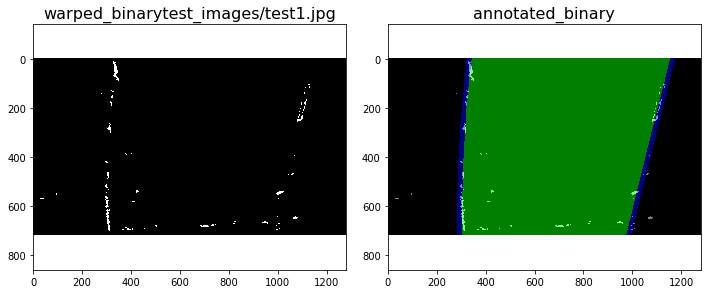

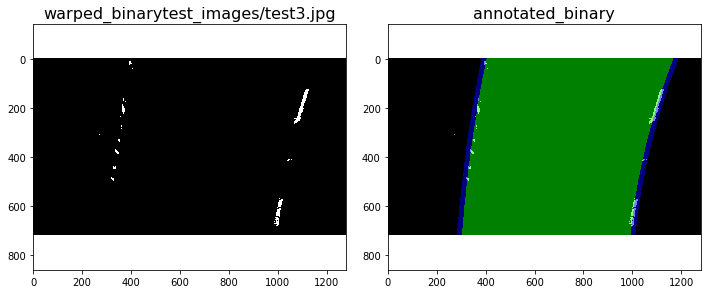

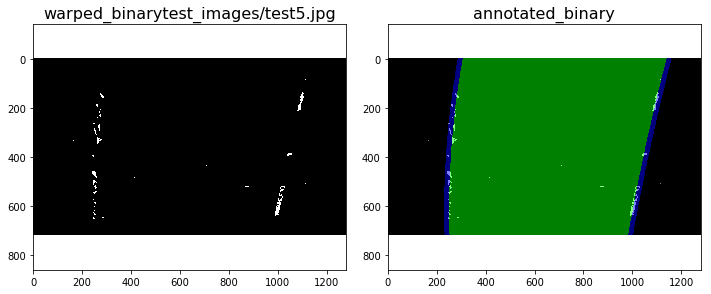

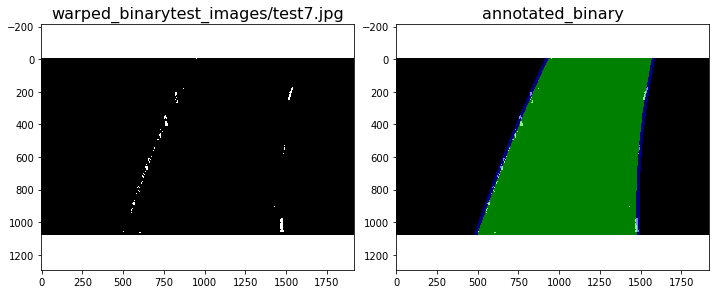

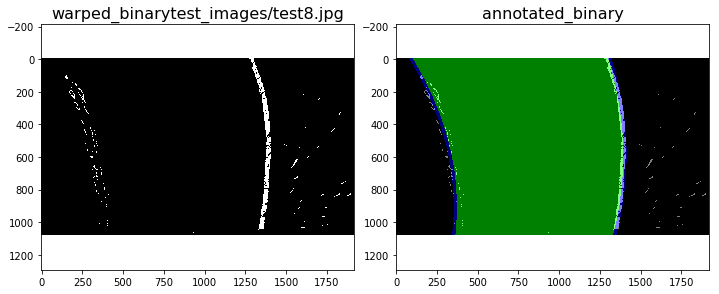

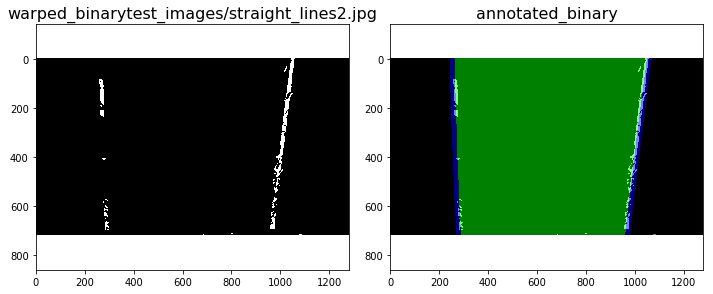

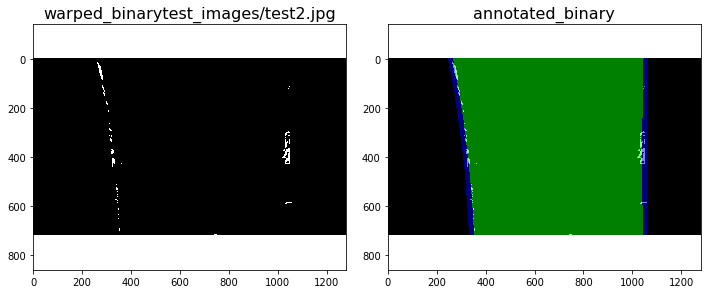

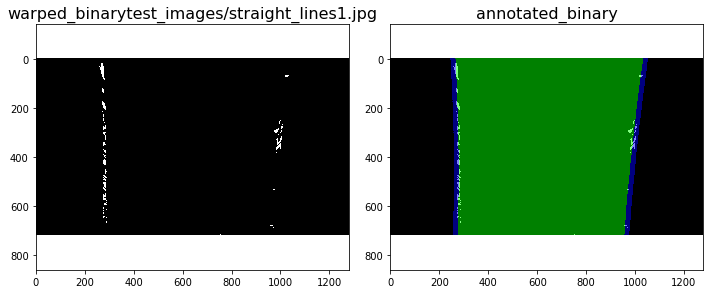

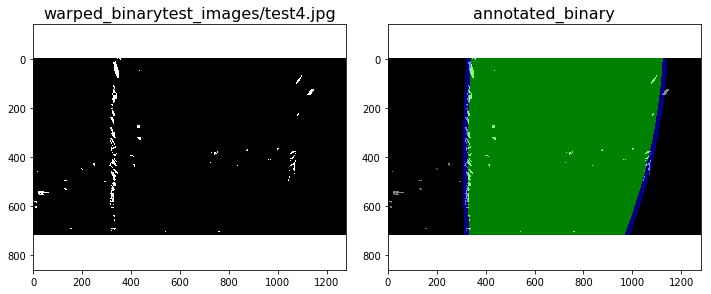

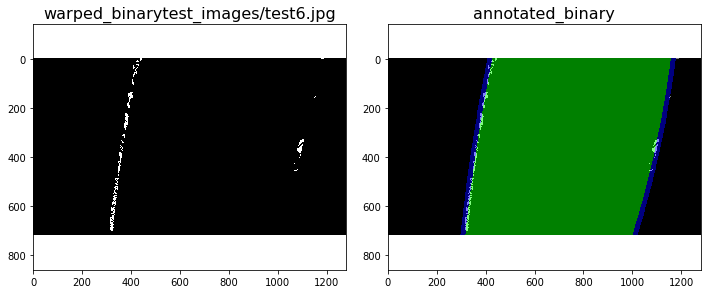

In [12]:
img_list = glob.glob('test_images/*.jpg')
for image in img_list:
    # global variable
    leftx_global = []
    lefty_global = []
    rightx_global = []
    righty_global = []
    pipeline(image, display=True)

### Determine the curvature of the road
    

For a curve: Y = Ax^2 +Bx + C
![alt text](radius.png)


where: dy/dx = 2A(X)+B, 

and d^2y/dx^2 = 2A

given radius: 500
calculated radius = 522 m right


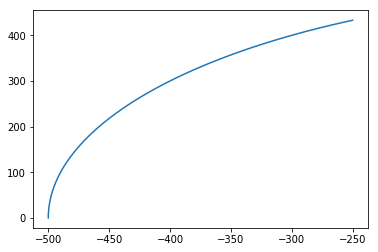

In [13]:
# Measure Radius of Curvature

def get_distance(x1=0,y1=0,z1=0,x2=0,y2=0,z2=0):
    """
    Calculate the distance between two pixels
        x1,y1,z1 = coordinates of point 1
        x2,y2,z2 = coordinates of point 2
    """
    d = ((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)**0.5
    return d

def get_mid(x1=0,y1=0,z1=0,x2=0,y2=0,z2=0):
    """
    Calculate the midpoint
        x1,y1,z1 = coordinates of point 1
        x2,y2,z2 = coordinates of point 2
    """
    mid_x = int((x1+x2)/2)
    mid_y = int((y1+y2)/2)
    mid_z = int((z1+z2)/2)
    return mid_x, mid_y, mid_z
    
    
def find_curvature(leftx_fit, lefty_fit, rightx_fit, righty_fit, pixel=True, report=False):
    """
    Find the radius of curvature of the road
        left_x, left_y = array holding the coordinates for left lane
        right_x, right_y = array holding the coordinates for right lane
    """
    if pixel==True:
        y_meter_per_pixel = 30./720 # meters per pixel in y dimension
        x_meter_per_pixel = 3.7/700 # meteres per pixel in x dimension
    else:
        y_meter_per_pixel = 1
        x_meter_per_pixel = 1
        
#     center_x = (np.array(leftx_fit)+np.array(rightx_fit))*0.5 * x_meter_per_pixel
#     center_y = np.array(lefty_fit) * y_meter_per_pixel
    
    center_coef = np.polynomial.polynomial.polyfit(lefty_fit, leftx_fit, 2)
    
    radius = ((1 + (2*center_coef[2]*np.median(lefty_fit) + center_coef[1])**2)**(3./2.))/abs(2*center_coef[2])
    radius = int(radius)
    
    
    if (radius > 8000):
        direction = 'straight'
        radius = ' '
    else:
        if np.sum(np.diff(leftx_fit))>0:
            direction = 'right'
            radius = str(radius) + ' m'
        elif np.sum(np.diff(leftx_fit))<0:
            direction = 'left'
            radius = str(radius) + ' m'
        elif (np.sum(np.diff(leftx_fit))==0):
            direction = 'straight'
            radius = ' '

    
        
        
    if report==True:
        print('Radius of curvature:',radius, direction)
    
    return radius, direction
    
    
    
    
    
# check the accuracy of the function
r = 500 # given radius
# create an arc using: arc = r*theta, theta is the angle in radians
# and x = r cos(theta), y = r sin(theta)
theta = np.linspace(180,120,100, endpoint=True)
x = [] 
y = []
for t in theta:
    x.append(r * np.cos(t*np.pi/180))
    y.append(r * np.sin(t*np.pi/180))

radius, direction = find_curvature(x,y,x,y, pixel=False, report=False)

plt.plot(x,y)

print('given radius:', r)
print('calculated radius =', radius, direction)


    
    

In [14]:

def pipeline(image, display=False):
    """
    Annotate the image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    binary_img, M_unwarp = create_binary(image, display=False)
    
    # detect lanes
    left_x, left_y, right_x, right_y = find_lanes(binary_img, display=False)
    
    # update buffers
    left_x, left_y = update_buffers(leftx_global, lefty_global,left_x, left_y)
    right_x, right_y = update_buffers(rightx_global, righty_global,right_x, right_y)
    
    # extrapolate detected points to a line
    leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(left_x, left_y, right_x, right_y, img.shape[0])
    # highlight lane lines and road path
    annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)
    # determine radius of curvature
    radius, direction = find_curvature(leftx_fit, lefty_fit, rightx_fit, righty_fit, pixel=True, report=False)
    
    # display results
    if display==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax0.set_title('warped_binary', fontsize=16)  
        ax0.imshow(binary_img, cmap='gray')
        
        ax1.set_title('Curvature: '+str(radius)+'  ' + direction, fontsize=16)  
        ax1.imshow(annotated_binary)
   
    return

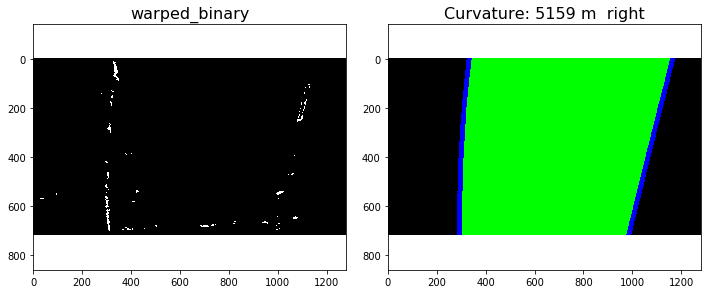

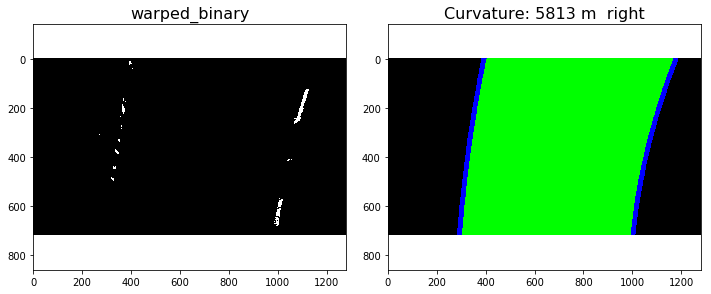

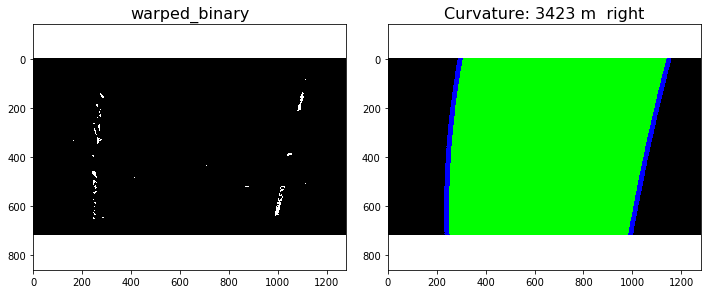

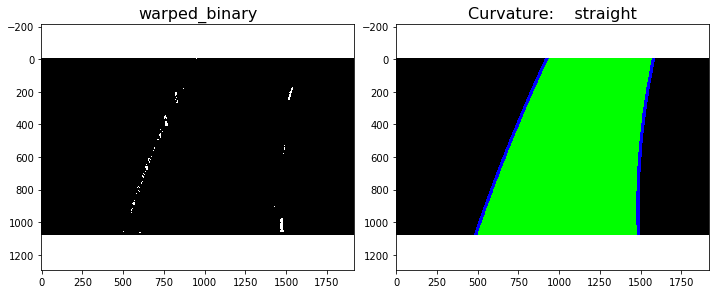

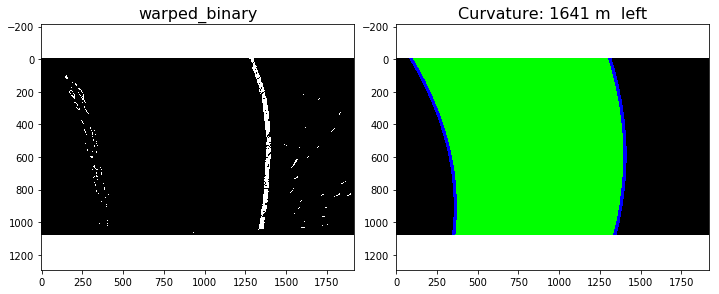

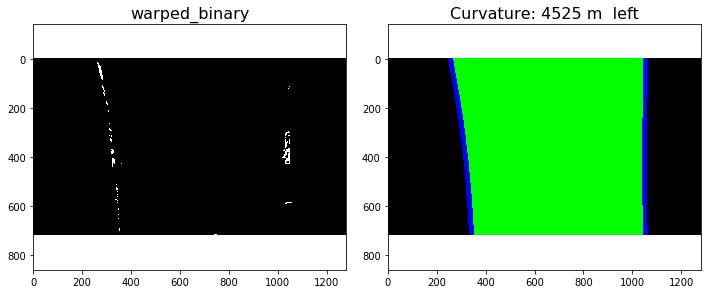

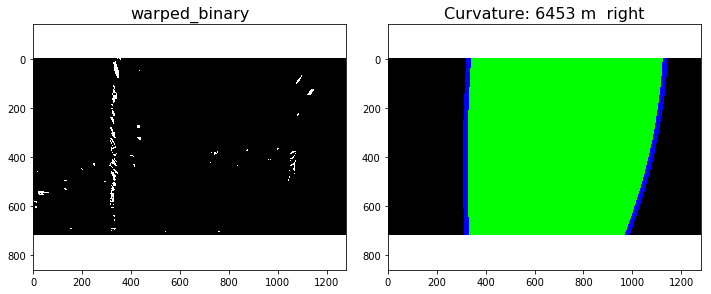

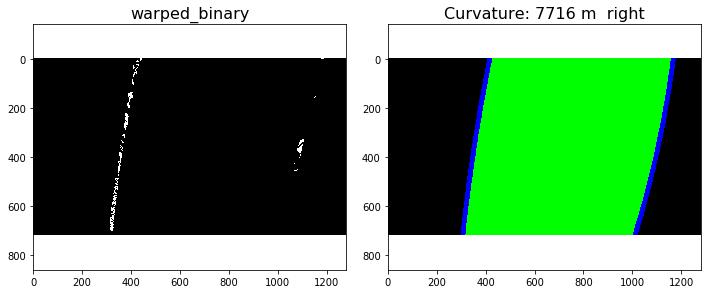

In [15]:
img_list = glob.glob('test_images/test*.jpg')
for img in img_list:
    # global variable
    leftx_global = []
    lefty_global = []
    rightx_global = []
    righty_global = []
    pipeline(img, display=True)

### Determine the vehicle position with respect to center.

In [16]:
def vehicle_position(leftx_fit, rightx_fit, image, pixel=True, report=True):
    """
    Determine the vehicle position from the center
        left_x, left_y = array holding the coordinates for left lane
        right_x, right_y = array holding the coordinates for right lane
        
        return: offset = positive for right, negative for left
    """
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    if pixel==True:
        y_meter_per_pixel = 30./720 # meters per pixel in y dimension
        x_meter_per_pixel = 3.7/700 # meteres per pixel in x dimension
    else:
        y_meter_per_pixel = 1
        x_meter_per_pixel = 1
        
    mid = int(img.shape[1]/2)
    position = int((leftx_fit[0]+rightx_fit[0])/2)
    offset = round((position - mid) * x_meter_per_pixel,2)
    
    if offset > 0:
        leaning = ' right '
    elif offset < 0:
        leaning = ' left '
    else:
        leaning = ' '
        
    offset = str(abs(offset)) + ' m'
    
    if report==True:
        print('Position from center:',leaning, offset)
    
    return offset, leaning


def pipeline(image, display=False):
    """
    Annotate the image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    binary_img, M_unwarp = create_binary(image, display=False)
    
    # detect lanes
    left_x, left_y, right_x, right_y = find_lanes(binary_img, display=False)
    
    # update buffers
    left_x, left_y = update_buffers(leftx_global, lefty_global,left_x, left_y)
    right_x, right_y = update_buffers(rightx_global, righty_global,right_x, right_y)
    
    # extrapolate detected points to a line
    leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(left_x, left_y, right_x, right_y, img.shape[0])
    
    # highlight lane lines and road path
    annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)
    
    # determine radius of curvature
    radius, direction = find_curvature(leftx_fit, lefty_fit, rightx_fit, righty_fit, pixel=True, report=False)
    
    # determine vehicle position from the center of the road
    offset, leaning = vehicle_position(leftx_fit, rightx_fit, img, report=False)
    
    # display results
    if display==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax0.set_title('warped_binary', fontsize=16)  
        ax0.imshow(binary_img, cmap='gray')
        
        ax1.set_title('Position: '+ str(leaning) + '  ' + str(offset) , fontsize=16)  
        ax1.imshow(annotated_binary)
   
    return
    


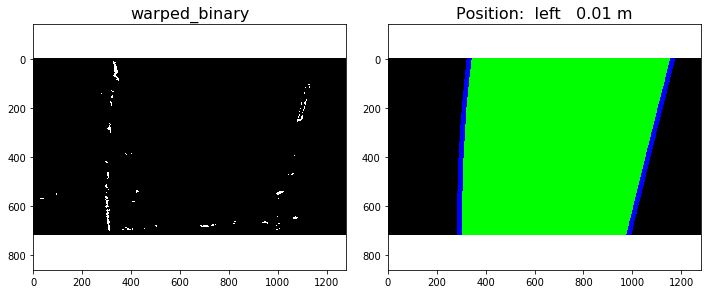

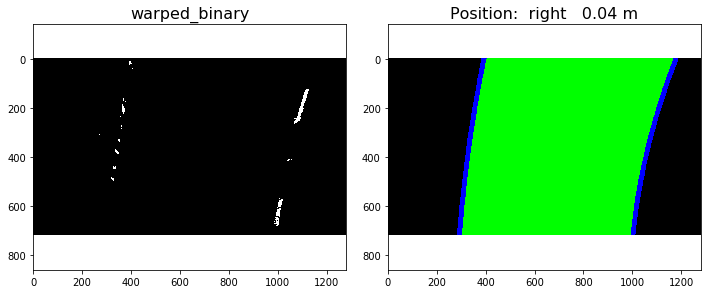

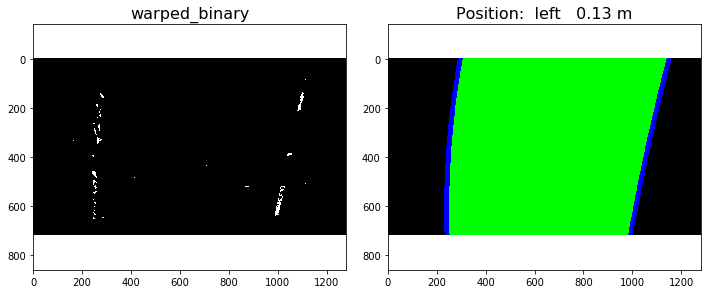

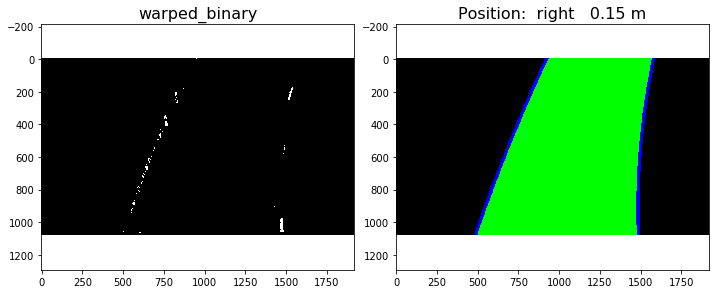

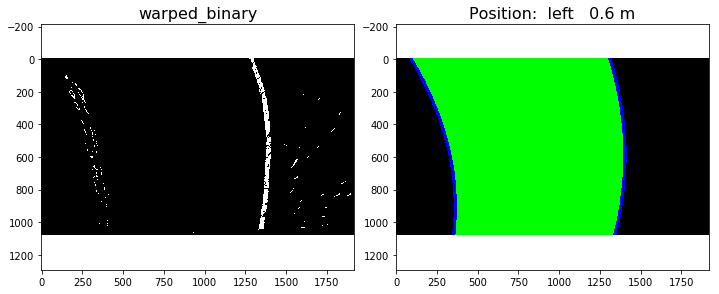

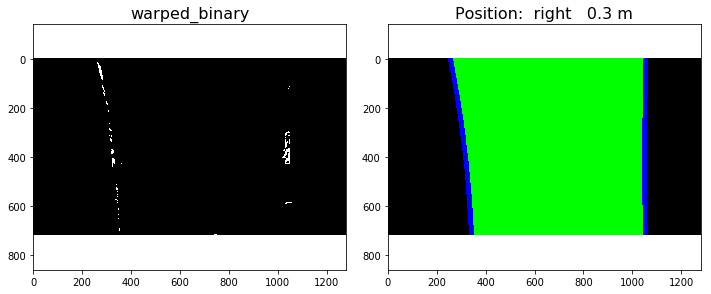

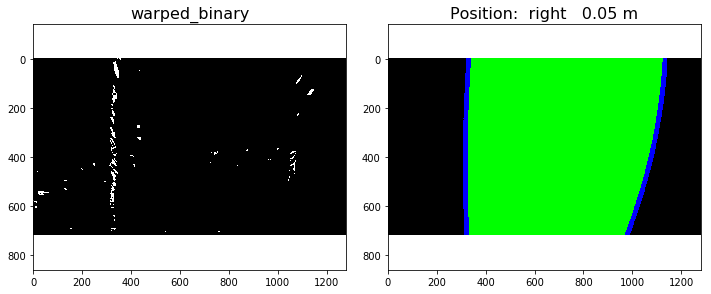

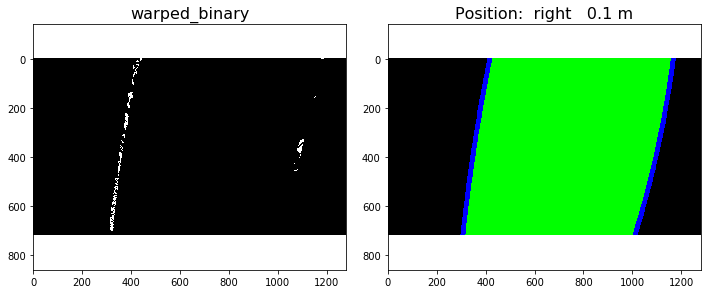

In [17]:
img_list = glob.glob('test_images/test*.jpg')
for img in img_list:
    # global variable
    leftx_global = []
    lefty_global = []
    rightx_global = []
    righty_global = []

    pipeline(img, display=True)

### Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 
    

In [18]:

def unwarp(image, warped_binary, M_unwarp, display=False):
    """
    Restore the warped binary image and add annotations to original image
        image = original image file
        warped_binary = warped binary image
        M_unwarp = matrix value to restore the warped image to original perspective
    """
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    imshape = warped_binary.shape
    img2 = cv2.warpPerspective(warped_binary, M_unwarp, (imshape[1], imshape[0]))
    img2 = cv2.addWeighted(img, 1, img2, 0.5, 0)
    
    if display==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax0.set_title('Original', fontsize=16)  
        ax0.imshow(img)
        
        ax1.set_title('Annotated', fontsize=16)  
        ax1.imshow(img2)
    
    return img2

def write_to_image(img,text,origin=(10,10),color=(0,255,0)):
    """Write texts to an image"""
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    thickness = 4
    cv2.putText(img,text,origin, font, font_scale,color,thickness,cv2.LINE_AA)
    return img


def pipeline(image, display=False):
    """
    Annotate the image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    
    try:
        img = cv2.imread(image)
    except:
        img = image
        
    binary_img, M_unwarp = create_binary(image, display=False)
    imgsize=(img.shape[1],img.shape[0])
    
    # detect lanes
    left_x, left_y, right_x, right_y = find_lanes(binary_img, display=False)
    
    # update buffers
    left_x, left_y = update_buffers(leftx_global, lefty_global,left_x, left_y, buffersize=10000)
    right_x, right_y = update_buffers(rightx_global, righty_global,right_x, right_y, buffersize=5000)
    
    # extrapolate detected points to a line
    leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(left_x, left_y, right_x, right_y, img.shape[0])

    # highlight lane lines and road path
    annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)

    # determine radius of curvature
    radius, direction = find_curvature(leftx_fit, lefty_fit, rightx_fit, righty_fit, pixel=True, report=False)

    # determine vehicle position from the center of the road
    offset, leaning = vehicle_position(leftx_fit, rightx_fit, img, report=False)

    # warp back to original perspective
    unwarped = unwarp(image, annotated_binary, M_unwarp, display=False)

    # write radius curvature and offset to the image
    text_curve = 'Curvature: ' + direction + ' ' + radius
    text_offset = 'Position: ' + leaning + offset + ' from center'
    annotated = write_to_image(unwarped,text_curve,origin=(int(imgsize[1]*0.05),int(imgsize[1]*0.1)),color=(0,255,0))
    annotated = write_to_image(unwarped,text_offset,origin=(int(imgsize[1]*0.05),int(imgsize[1]*0.2)),color=(0,255,0))

    
    # display results
    if display==True:
        f, ((ax0, ax1)) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
            
        ax0.set_title('Original', fontsize=16)  
        ax0.imshow(img)
        
        ax1.set_title('Annotated', fontsize=16)  
        ax1.imshow(annotated)
    
   
    return
   


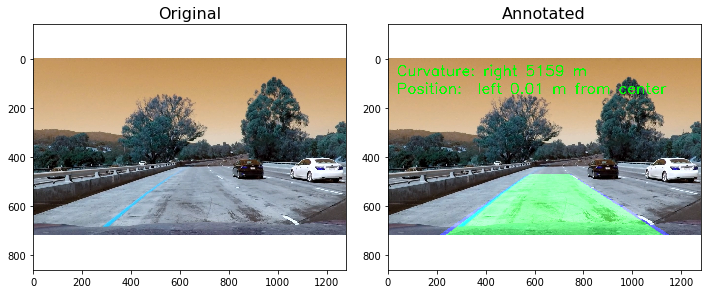

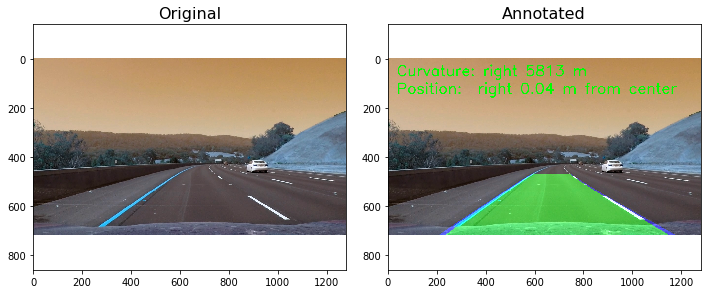

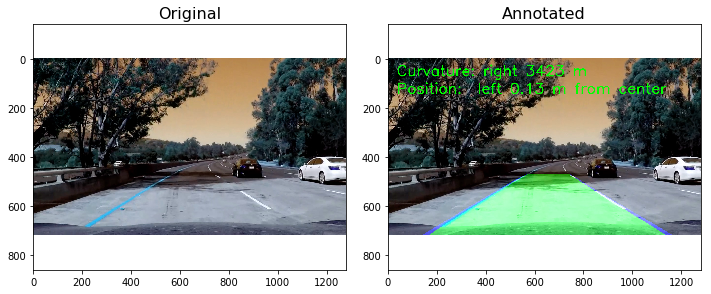

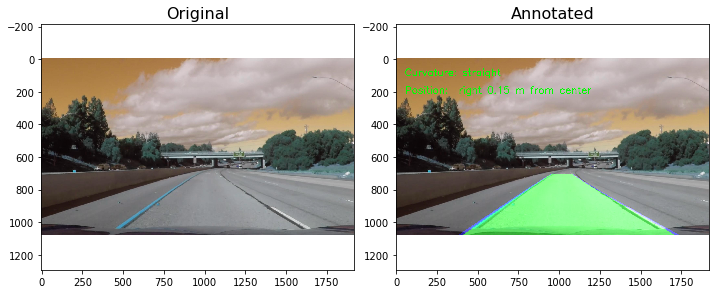

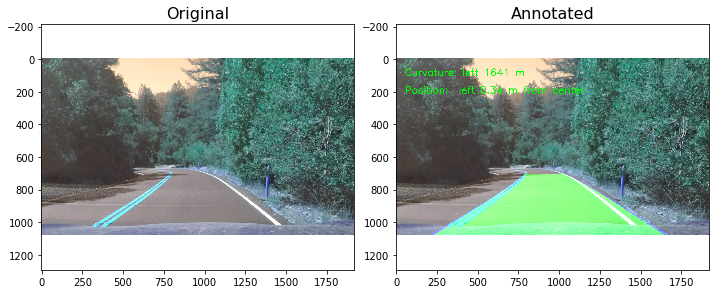

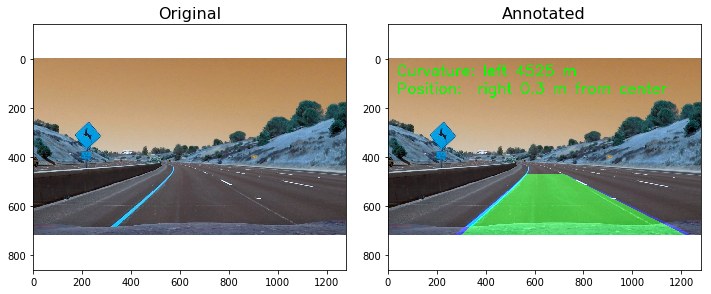

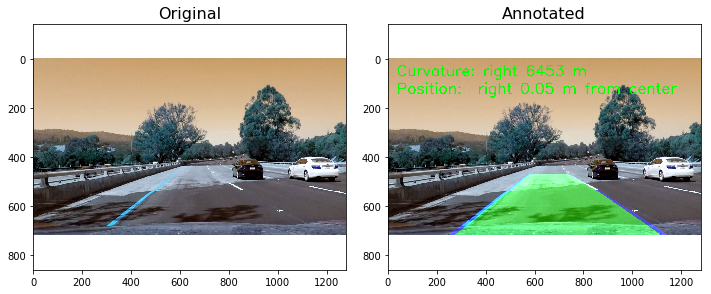

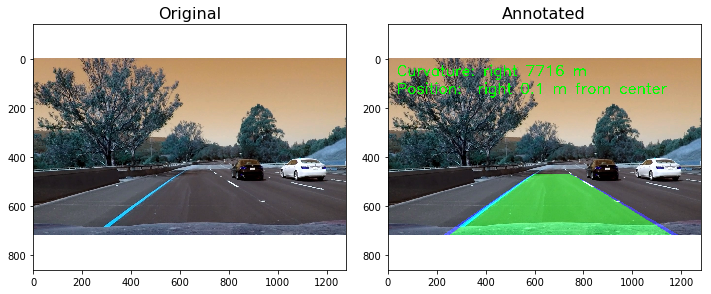

In [19]:
img_list = glob.glob('test_images/test*.jpg')
for img in img_list:
    # global variable
    leftx_global = []
    lefty_global = []
    rightx_global = []
    righty_global = []
    
    pipeline(img, display=True)

## Test on Videos



In [20]:

def video_pipeline(image):
    """
    Annotate the image
    """
    
    global leftx_global, lefty_global, rightx_global, righty_global
    global counter, radius, direction, offset, leaning
    
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
    binary_img, M_unwarp = create_binary(img, display=False)
    imgsize = (img.shape[1],img.shape[0])
    
    # detect lanes
    left_x, left_y, right_x, right_y = find_lanes(binary_img, display=False)
    
    # update buffers
    leftx_global, lefty_global = update_buffers(leftx_global, lefty_global, left_x, left_y, buffersize=40000)
    rightx_global, righty_global, = update_buffers(rightx_global, righty_global, right_x, right_y, buffersize=30000)
    
    if len(leftx_global) > 0 and len(rightx_global) > 0:
        # extrapolate detected points to a line
        leftx_fit, lefty_fit, rightx_fit, righty_fit = fit_line(leftx_global, lefty_global, rightx_global, righty_global, img.shape[0])

        # highlight lane lines and road path
        annotated_binary = draw_lanes(leftx_fit, lefty_fit, rightx_fit, righty_fit, binary_img, color=[255, 0, 0], thickness=20)
        
        # adjust curvature and offset data
        if counter < 1:
            # determine radius of curvature
            radius, direction = find_curvature(leftx_fit, lefty_fit, rightx_fit, righty_fit, pixel=True, report=False)
            counter = 5
            # determine vehicle position from the center of the road
            offset, leaning = vehicle_position(leftx_fit, rightx_fit, img, report=False)
        else:
            counter -= 1
        # warp back to original perspective
        unwarped = unwarp(image, annotated_binary, M_unwarp, display=False)

        # write radius curvature and offset to the image
        text_curve = 'Curvature: ' + direction + ' ' + radius
        text_offset = 'Position: ' + leaning + offset + ' from center'
        annotated = write_to_image(unwarped,text_curve,origin=(int(imgsize[1]*0.05),int(imgsize[1]*0.1)),color=(0,255,0))
        annotated = write_to_image(unwarped,text_offset,origin=(int(imgsize[1]*0.05),int(imgsize[1]*0.2)),color=(0,255,0))

        return annotated
    
    else:
        print('No lane detected.')
        
        return img
    
   



### Project Video

In [21]:
# global variable
global leftx_global, lefty_global, rightx_global, righty_global
global counter, radius, direction, offset, leaning
counter = 0
leftx_global = []
lefty_global = []
rightx_global = []
righty_global = []

video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [06:26<00:00,  4.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 



In [22]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_result.mp4'))

### Challenge Video

In [23]:

# global variable
global leftx_global, lefty_global, rightx_global, righty_global
global counter, radius, direction, offset, leaning
counter = 0
leftx_global = []
lefty_global = []
rightx_global = []
righty_global = []

video_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(video_pipeline) 
challenge_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [01:54<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Harder Challenge Video

In [25]:

# global variable
global leftx_global, lefty_global, rightx_global, righty_global

leftx_global = []
lefty_global = []
rightx_global = []
righty_global = []

video_output = 'harder_challenge_result.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
challenge_clip = clip1.fl_image(video_pipeline) 
challenge_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_result.mp4
[MoviePy] Writing video harder_challenge_result.mp4


100%|█████████▉| 1199/1200 [04:58<00:00,  4.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_result.mp4 



In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Reflections


#### Algorithm Limitations
This algorithm successfully detects the lane lines in the given videos including the challenge video when the car is situated approximately within the lane boundaries. However, it might not be able to correctly detect the lane path in situations when one or both of the lane lines are missing, perhaps because of a sharp turn, or defects of the road.

#### Room for improvements
There are still a lot of space for improvement for this algorithm especially in processing the image to filter out noises and emphasize lane lines. It would also be much more beneficial if the algorithm can estimate the path to follow even in the absence of lane markings as in the case of dirt roads or when the markings are not clear.

#### Hurdles and Lessons Learned
Bulk of the effort done in this project is on image processing-using the right color channels and thresholds as well as tweaking the parameters for blurring and contrasting. There are aspects of the project that are simple yet tricky. In my case, I was baffled why my algorithm could not detect the lane lines when I use it in the video pipeline, yet it was successful with the test images. The main culprit wast that my algorithm works with BGR colorspace and the video clip is feeding RGB images. This small detail proved to be fundamental and it consumed much of my time troubleshooting my thresholds and image processing where, in fact, I was looking at the wrong direction. 